## Load features dataset

In [1]:
import numpy as np
import pandas as pd
import os
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
features_folder = '/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Dataset/1_Processed/CSI_Features/2-seconds'
features_list = [f for f in os.listdir(features_folder) if f.endswith('.csv')]

dfs = []
for file_name in features_list:
    # We will use data of day 1 and 2 for cross validation
    match = re.search(r"csi-features-full-d(\d+)-(\d+)", file_name)
    if match:
      print(file_name)
      label = match.group(2)
      print("label:", label)
      file_path = os.path.join(features_folder, file_name)
      df = pd.read_csv(file_path)
      df["label"] = int(label)
      dfs.append(df)
print("Number of dataframes loaded: ", len(dfs))

csi-features-full-d2-0.csv
label: 0
csi-features-full-d2-5.csv
label: 5
csi-features-full-d2-4.csv
label: 4
csi-features-full-d1-0.csv
label: 0
csi-features-full-d2-1.csv
label: 1
csi-features-full-d1-5.csv
label: 5
csi-features-full-d1-1.csv
label: 1
csi-features-full-d1-3.csv
label: 3
csi-features-full-d2-3.csv
label: 3
csi-features-full-d1-2.csv
label: 2
csi-features-full-d1-4.csv
label: 4
csi-features-full-d2-2.csv
label: 2
Number of dataframes loaded:  12


## Split and stratify

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

In [37]:
df_fea_all = pd.DataFrame()

for i in range(len(dfs)):
    df_fea_all = pd.concat([df_fea_all, dfs[i]], axis=0)

df_fea_all.reset_index(drop=True)


,std_subcarrier_0,mean_subcarrier_0,max_subcarrier_0,min_subcarrier_0,qtu_subcarrier_0,qtl_subcarrier_0,iqr_subcarrier_0,std_subcarrier_1,mean_subcarrier_1,max_subcarrier_1,...,std_subcarrier_51,mean_subcarrier_51,max_subcarrier_51,min_subcarrier_51,qtu_subcarrier_51,qtl_subcarrier_51,iqr_subcarrier_51,euc,rss_std,label
0,2.103277,23.369059,28.606596,17.618135,24.874141,21.991571,2.882570,3.157244,23.125368,37.042778,...,3.056277,18.854448,27.331163,11.309914,20.800982,16.872003,3.928979,5.151410,1.578599,0
1,2.909761,20.416104,26.273369,13.499631,22.440983,18.561425,3.879558,2.941264,20.403220,28.529009,...,2.624134,21.402739,30.982557,14.664892,22.666078,19.948567,2.717512,5.258728,1.920937,0
2,2.824107,20.180957,29.025760,13.499631,21.907816,18.397821,3.509994,2.382504,19.606965,28.510313,...,2.321220,23.608709,30.688856,18.569834,24.907540,21.821006,3.086534,5.343872,2.174713,0
3,4.076953,21.807240,37.560180,16.139448,22.509327,19.227167,3.282160,4.008680,21.081791,37.263683,...,3.370577,24.070076,35.193375,15.480557,25.613805,21.711440,3.902364,5.795658,3.081737,0
4,5.674097,23.566017,40.863857,12.458707,27.087658,18.533369,8.554289,5.539030,23.347733,40.312256,...,2.334564,21.016329,27.270285,14.633410,22.641921,19.727819,2.914102,7.376381,2.899293,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,4.407037,23.565369,33.862118,14.271717,27.218835,19.864076,7.354758,4.740822,23.279829,36.438824,...,5.778313,10.258298,26.066298,1.079711,15.061314,5.161459,9.899855,6.348018,3.378742,2
2610,5.334467,24.588053,48.334194,14.271717,26.339586,20.958907,5.380679,5.166259,23.966459,49.410103,...,4.880663,9.654083,26.066298,2.213527,12.528736,5.855433,6.673303,5.883613,3.233203,2
2611,3.169494,27.781928,45.855274,20.593643,29.279415,25.302284,3.977131,2.947184,27.021903,46.324154,...,2.807999,5.253970,12.141993,1.296008,6.340766,2.967187,3.373579,4.972565,2.171981,2
2612,2.863907,26.460411,34.284477,18.937760,28.407940,24.751476,3.656463,2.731183,26.114935,33.516094,...,1.646340,3.814695,8.917441,1.239547,4.874395,2.447977,2.426418,4.803537,2.278020,2


In [23]:
# Combine all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Split the combined dataframe into features (X) and labels (Y)
X = combined_df.drop(columns=["label"])
Y = combined_df["label"]

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (1260, 414)
Shape of Y: (1260,)


In [38]:
# set k for k-hold cross-validation
k = 7

X = df_fea_all.drop('label', axis=1)
y = df_fea_all['label']

X = X.reset_index()
X = X.drop('index', axis = 1)
y = y.reset_index()
y = y.drop('index', axis = 1)

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
X = pd.DataFrame(X)

skf = StratifiedKFold(n_splits=k)

train_index = [[] for _ in range(k)]
test_index = [[] for _ in range(k)]

n = 0
for tra_idx, tes_idx in skf.split(X,y):

    print('##### Stratified k-fold',n+1,'#####')
    print("TRAIN: ",len(tra_idx))
    print("TEST: ",len(tes_idx))

    train_index[n] = tra_idx
    test_index[n] = tes_idx

    n += 1

##### Stratified k-fold 1 #####
TRAIN:  2240
TEST:  374
##### Stratified k-fold 2 #####
TRAIN:  2240
TEST:  374
##### Stratified k-fold 3 #####
TRAIN:  2240
TEST:  374
##### Stratified k-fold 4 #####
TRAIN:  2241
TEST:  373
##### Stratified k-fold 5 #####
TRAIN:  2241
TEST:  373
##### Stratified k-fold 6 #####
TRAIN:  2241
TEST:  373
##### Stratified k-fold 7 #####
TRAIN:  2241
TEST:  373


## DNNR Training

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [8]:
early_stopping =  EarlyStopping(
                            monitor='val_mae',
                            min_delta=0,
                            patience=100,
                            verbose=1,
                            mode='auto')

In [45]:
def compare_TV(history, train_met, val_met):
    acc = history.history[train_met]
    val_acc = history.history[val_met]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo' ,label = 'training '+train_met)
    plt.plot(epochs, val_acc, 'b' , label= 'validation '+val_met)
    plt.title('Training and Validation metrics')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.8727 - mae: 1.6853 - val_loss: 1.8312 - val_mae: 1.0286
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7265 - mae: 0.9543 - val_loss: 0.8292 - val_mae: 0.6584
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1012 - mae: 0.7655 - val_loss: 0.6512 - val_mae: 0.5914
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9537 - mae: 0.7109 - val_loss: 0.6139 - val_mae: 0.5783
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8268 - mae: 0.6552 - val_loss: 0.6394 - val_mae: 0.5793
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8054 - mae: 0.6441 - val_loss: 0.5520 - val_mae: 0.5489
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7634 - mae: 0.6440 - val_loss: 0.6830 - val_mae: 0.5906
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6923 - mae: 0.5984 - val_loss: 0.4646 - val_mae: 0.4949
Epoch 9/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/

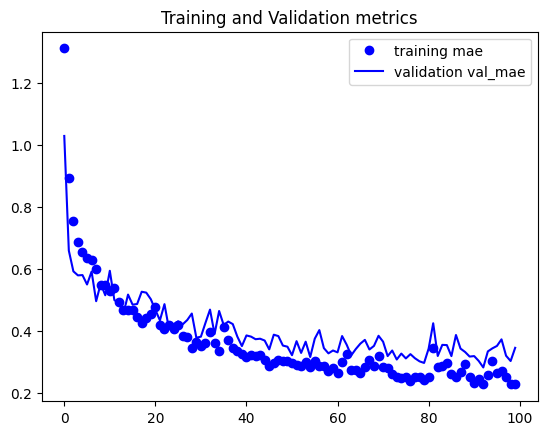

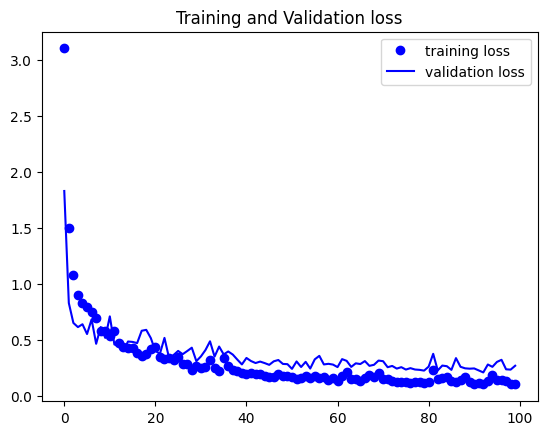

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 3.2750 - mae: 1.3769 - val_loss: 1.1850 - val_mae: 0.7864
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.2760 - mae: 0.8378 - val_loss: 0.9941 - val_mae: 0.7449
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0837 - mae: 0.7824 - val_loss: 0.8737 - val_mae: 0.6726
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9317 - mae: 0.7078 - val_loss: 0.8141 - val_mae: 0.6306
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8404 - mae: 0.6702 - val_loss: 0.7824 - val_mae: 0.6337
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6905 - mae: 0.5957 - val_loss: 0.6552 - val_mae: 0.5786
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6066 - mae: 0.5636 - val_loss: 0.7914 - val_mae: 0.6370
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6587 - mae: 0.5960 - val_loss: 0.6874 - val_mae: 0.5890
Epoch 9/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 

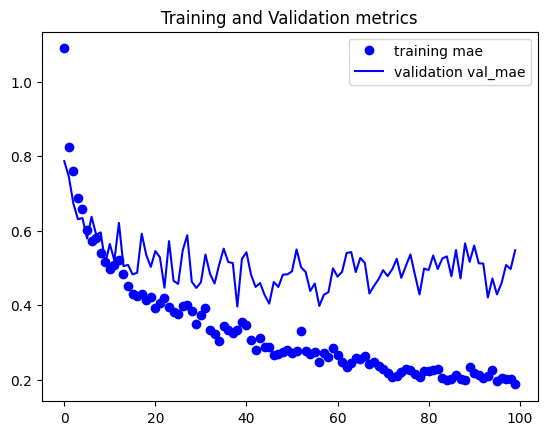

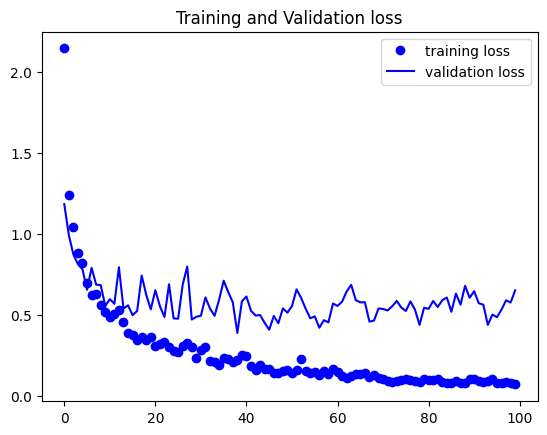

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 3.3150 - mae: 1.4095 - val_loss: 1.2783 - val_mae: 0.8380
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.2850 - mae: 0.8487 - val_loss: 0.8444 - val_mae: 0.7074
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0944 - mae: 0.7945 - val_loss: 0.7426 - val_mae: 0.5863
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8893 - mae: 0.6808 - val_loss: 0.6903 - val_mae: 0.5750
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9180 - mae: 0.6856 - val_loss: 0.5894 - val_mae: 0.5058
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7702 - mae: 0.6478 - val_loss: 0.7139 - val_mae: 0.5749
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6668 - mae: 0.6001 - val_loss: 0.5239 - val_mae: 0.4905
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5832 - mae: 0.5442 - val_loss: 0.6253 - val_mae: 0.5434
Epoch 9/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 

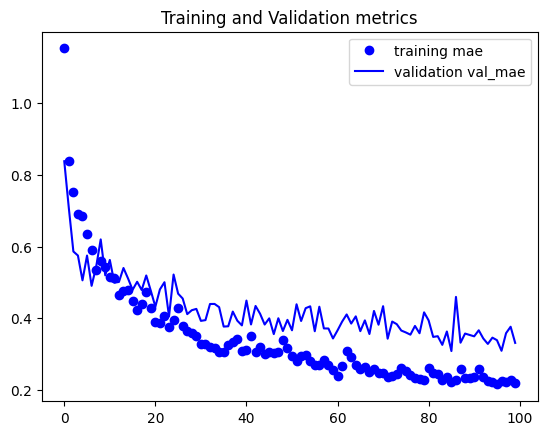

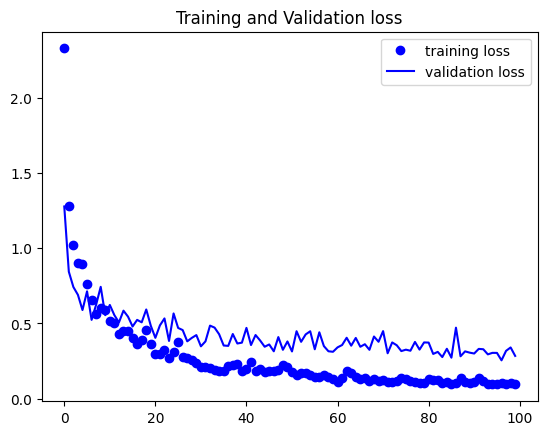

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.2317 - mae: 1.5941 - val_loss: 1.2502 - val_mae: 0.8806
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5768 - mae: 0.9450 - val_loss: 0.9175 - val_mae: 0.7099
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.1732 - mae: 0.8128 - val_loss: 1.0843 - val_mae: 0.7137
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0176 - mae: 0.7318 - val_loss: 0.6659 - val_mae: 0.5824
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7367 - mae: 0.6246 - val_loss: 0.8410 - val_mae: 0.6268
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7973 - mae: 0.6352 - val_loss: 0.6538 - val_mae: 0.5778
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.7209 - mae: 0.6069 - val_loss: 0.6004 - val_mae: 0.5375
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.6560 - mae: 0.5747 - val_loss: 0.5826 - val_mae: 0.5372
Epoch 9/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 

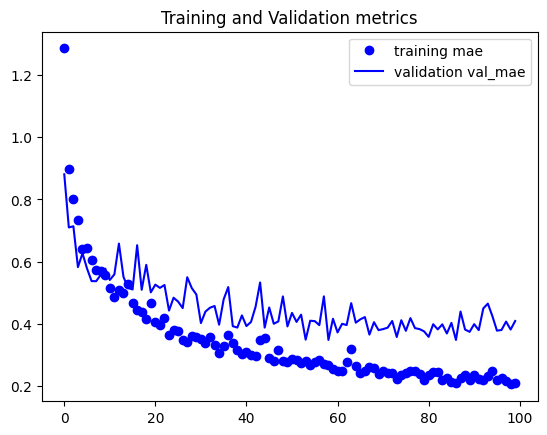

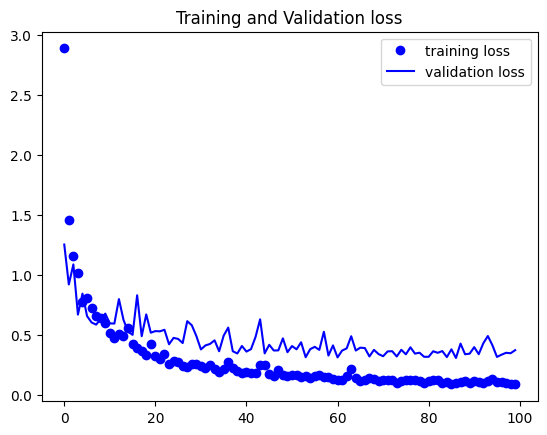

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.6924 - mae: 1.4558 - val_loss: 1.4299 - val_mae: 0.9100
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5743 - mae: 0.9334 - val_loss: 0.9284 - val_mae: 0.6578
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1848 - mae: 0.7918 - val_loss: 0.6816 - val_mae: 0.5877
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9702 - mae: 0.7285 - val_loss: 0.8010 - val_mae: 0.6419
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1047 - mae: 0.7467 - val_loss: 0.6449 - val_mae: 0.5665
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7804 - mae: 0.6325 - val_loss: 0.6349 - val_mae: 0.5713
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6515 - mae: 0.5772 - val_loss: 0.7999 - val_mae: 0.6254
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6265 - mae: 0.5704 - val_loss: 0.6825 - val_mae: 0.5907
Epoch 9/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 

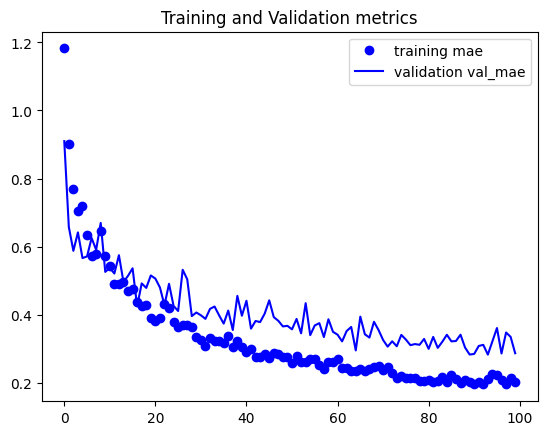

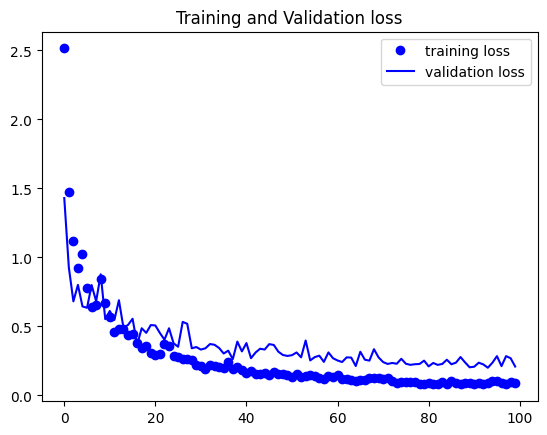

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
5
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.9514 - mae: 1.5429 - val_loss: 1.1463 - val_mae: 0.8252
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.5090 - mae: 0.9335 - val_loss: 0.9281 - val_mae: 0.6971
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.0112 - mae: 0.7507 - val_loss: 0.6810 - val_mae: 0.6295
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.8726 - mae: 0.6908 - val_loss: 0.9675 - val_mae: 0.7462
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.8153 - mae: 0.6637 - val_loss: 0.6387 - val_mae: 0.5964
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6537 - mae: 0.5935 - val_loss: 0.5784 - val_mae: 0.5375
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.5867 - mae: 0.5479 - val_loss: 0.6368 - val_mae: 0.5588
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.5677 - mae: 0.5601 - val_loss: 0.5760 - val_mae: 0.5416
Epoch 9/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 

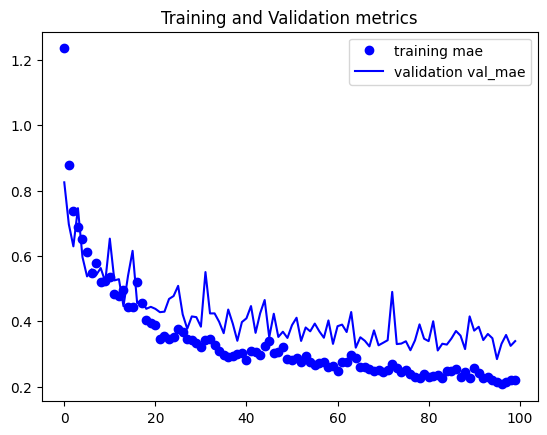

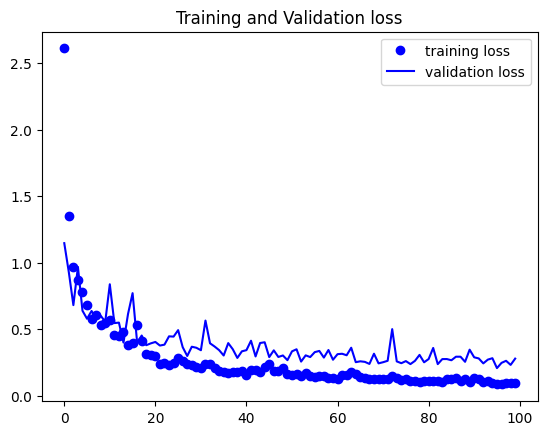

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
6
Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.4755 - mae: 1.5938 - val_loss: 1.3517 - val_mae: 0.8574
Epoch 2/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4173 - mae: 0.8937 - val_loss: 0.9419 - val_mae: 0.7058
Epoch 3/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2281 - mae: 0.8156 - val_loss: 0.9367 - val_mae: 0.6829
Epoch 4/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9868 - mae: 0.7128 - val_loss: 0.7847 - val_mae: 0.6491
Epoch 5/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.9407 - mae: 0.7063 - val_loss: 0.6887 - val_mae: 0.5899
Epoch 6/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7617 - mae: 0.6347 - val_loss: 0.6931 - val_mae: 0.6172
Epoch 7/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7285 - mae: 0.6151 - val_loss: 0.6117 - val_mae: 0.5449
Epoch 8/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8339 - mae: 0.6526 - val_loss: 0.5749 - val_mae: 0.5366
Epoch 9/1000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 

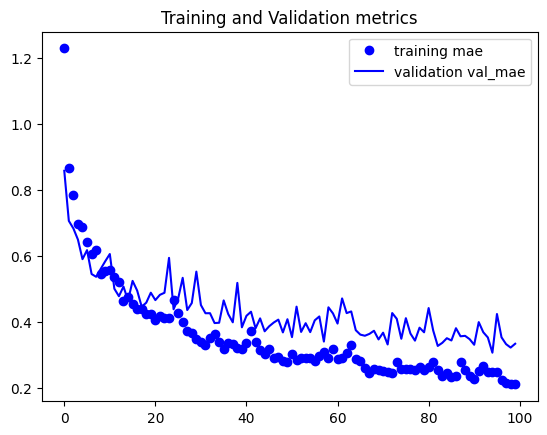

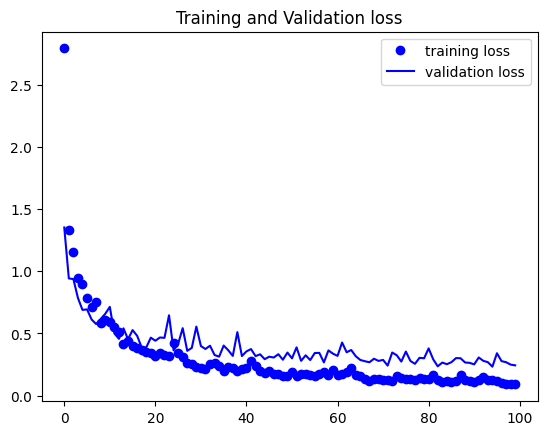

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7


In [46]:
y_test_list = [[] for _ in range(k)]
y_pred_list = [[] for _ in range(k)]


for i in range(k):

    X_train = X.iloc[train_index[i]]
    X_test = X.iloc[test_index[i]]
    y_train = y.iloc[train_index[i]]
    y_test = y.iloc[test_index[i]]

    # valdation data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100, stratify=y_train)

    # Feature standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train=scaler.transform(X_train)
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

    X_train = pd.DataFrame(X_train)
    X_val = pd.DataFrame(X_val)
    X_test = pd.DataFrame(X_test)

    model = Sequential()
    model.add(Dense(1000, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    opt = Adam(learning_rate=0.001)

    model.compile(optimizer=opt,
                  loss='mse',
                  metrics=['mae'])

    # fit
    history = model.fit(X_train, y_train,
                        batch_size=100,
                        epochs=1000,
                        verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=(early_stopping))

    compare_TV(history, "mae", "val_mae")

    # prediction
    y_pred = model.predict(X_test)

    y_test_list[i] = y_test
    y_pred_list[i] = y_pred

    print(i+1)

## Evaluation

In [47]:
for i in range(len(y_test_list)):
    y_test_list[i] = y_test_list[i].values

In [48]:
y_test_tot = []
y_pred_tot = []

for i in range(k):
    y_test_tot.extend(y_test_list[i])
    y_pred_tot.extend(y_pred_list[i])

In [49]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

In [50]:
# result scores

print('DNN')
print('###########################')
print('Med-abs-err: ',round(median_absolute_error(y_test_tot, y_pred_tot),4))
print('Max-err: ',round(max_error(y_test_tot, y_pred_tot),4))
print('R2_score: ',round(r2_score(y_test_tot, y_pred_tot),4))
print('###########################')

DNN
###########################
Med-abs-err:  0.2176
Max-err:  4.1317
R2_score:  0.8482
###########################


## Export model

In [51]:
import tensorflow as tf

model.save('/content/drive/MyDrive/UIT/UIT_Graduation_Thesis/Models/WiCount_FE_DNNR_2days.keras')